# Heart Disease

## Imports and Drive Mount

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/datasets/heart.csv')

In [3]:
# 5 first rows
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "heart diseases"
    df = df.dropna(axis=0) # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis=0)
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [8]:
# Drop empty columns
df_clean = df.drop(['oldpeak'], axis=1)

# Drop duplicate rows
df_clean = df_clean.drop_duplicates()

# Calculate the mean value of the restecg column
mean_value = df_clean['restecg'].mean()

# Impute missing values with the mean
df_clean['restecg'].fillna(value=mean_value, inplace=True)
print(f"Null or empty values in `restecg` column? {df_clean['restecg'].isna().any()}")

Null or empty values in `restecg` column? False


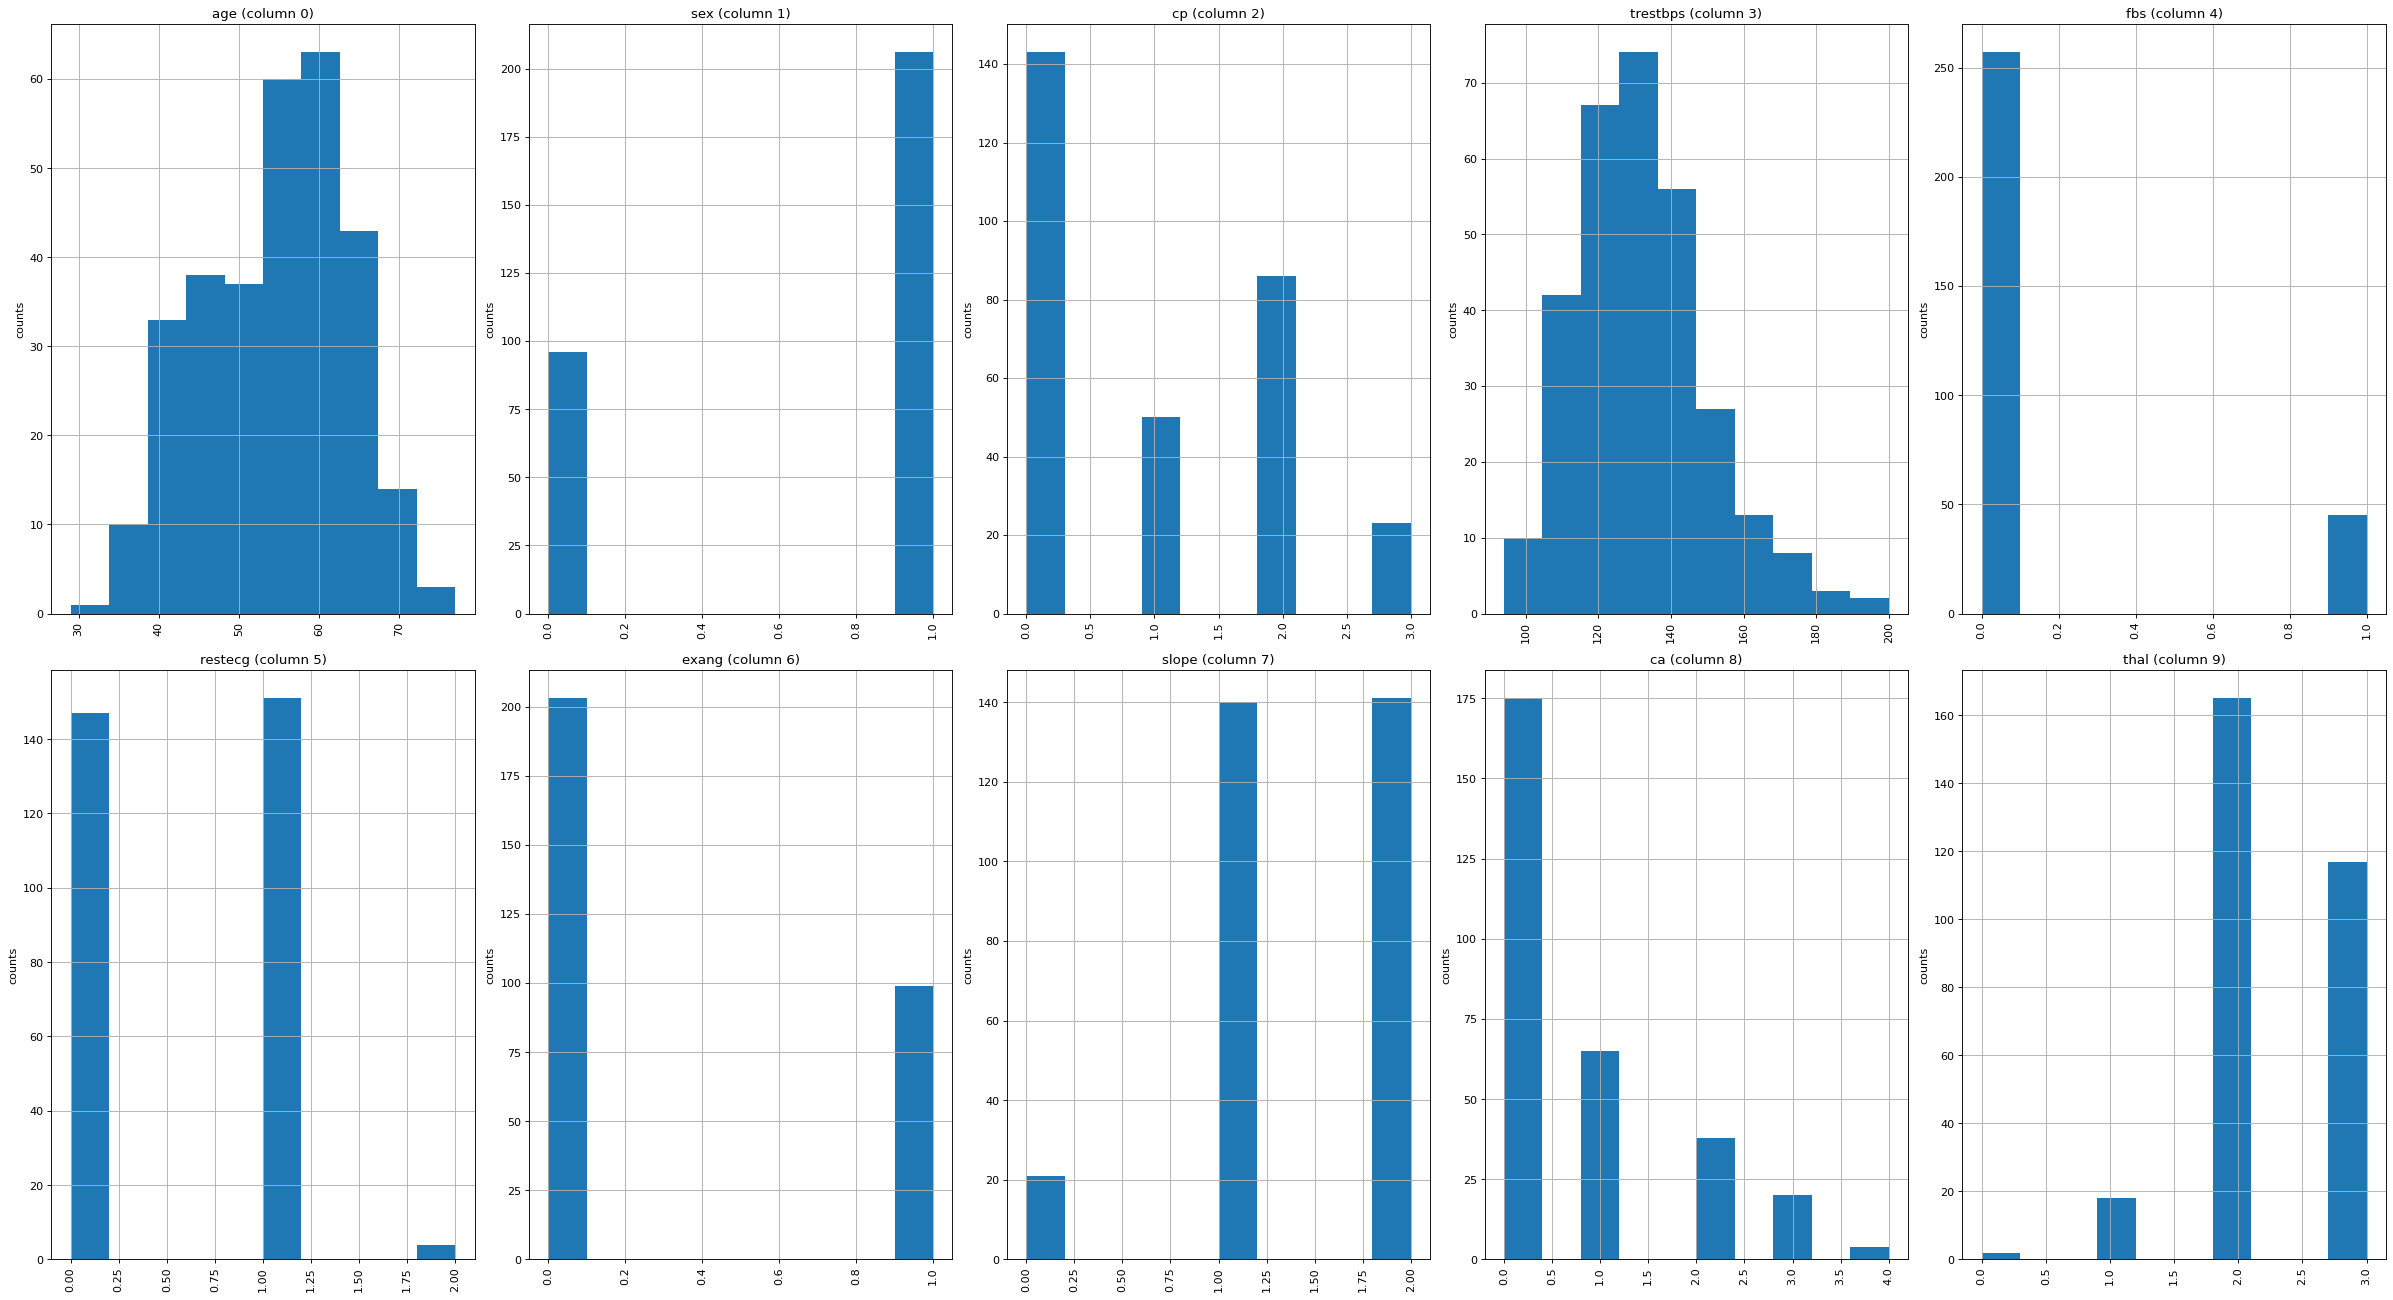

In [9]:
plotPerColumnDistribution(df_clean, 10, 5)

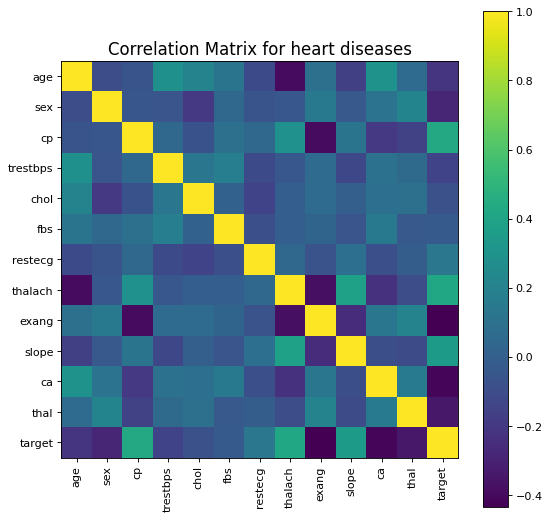

In [10]:
plotCorrelationMatrix(df_clean, 8)

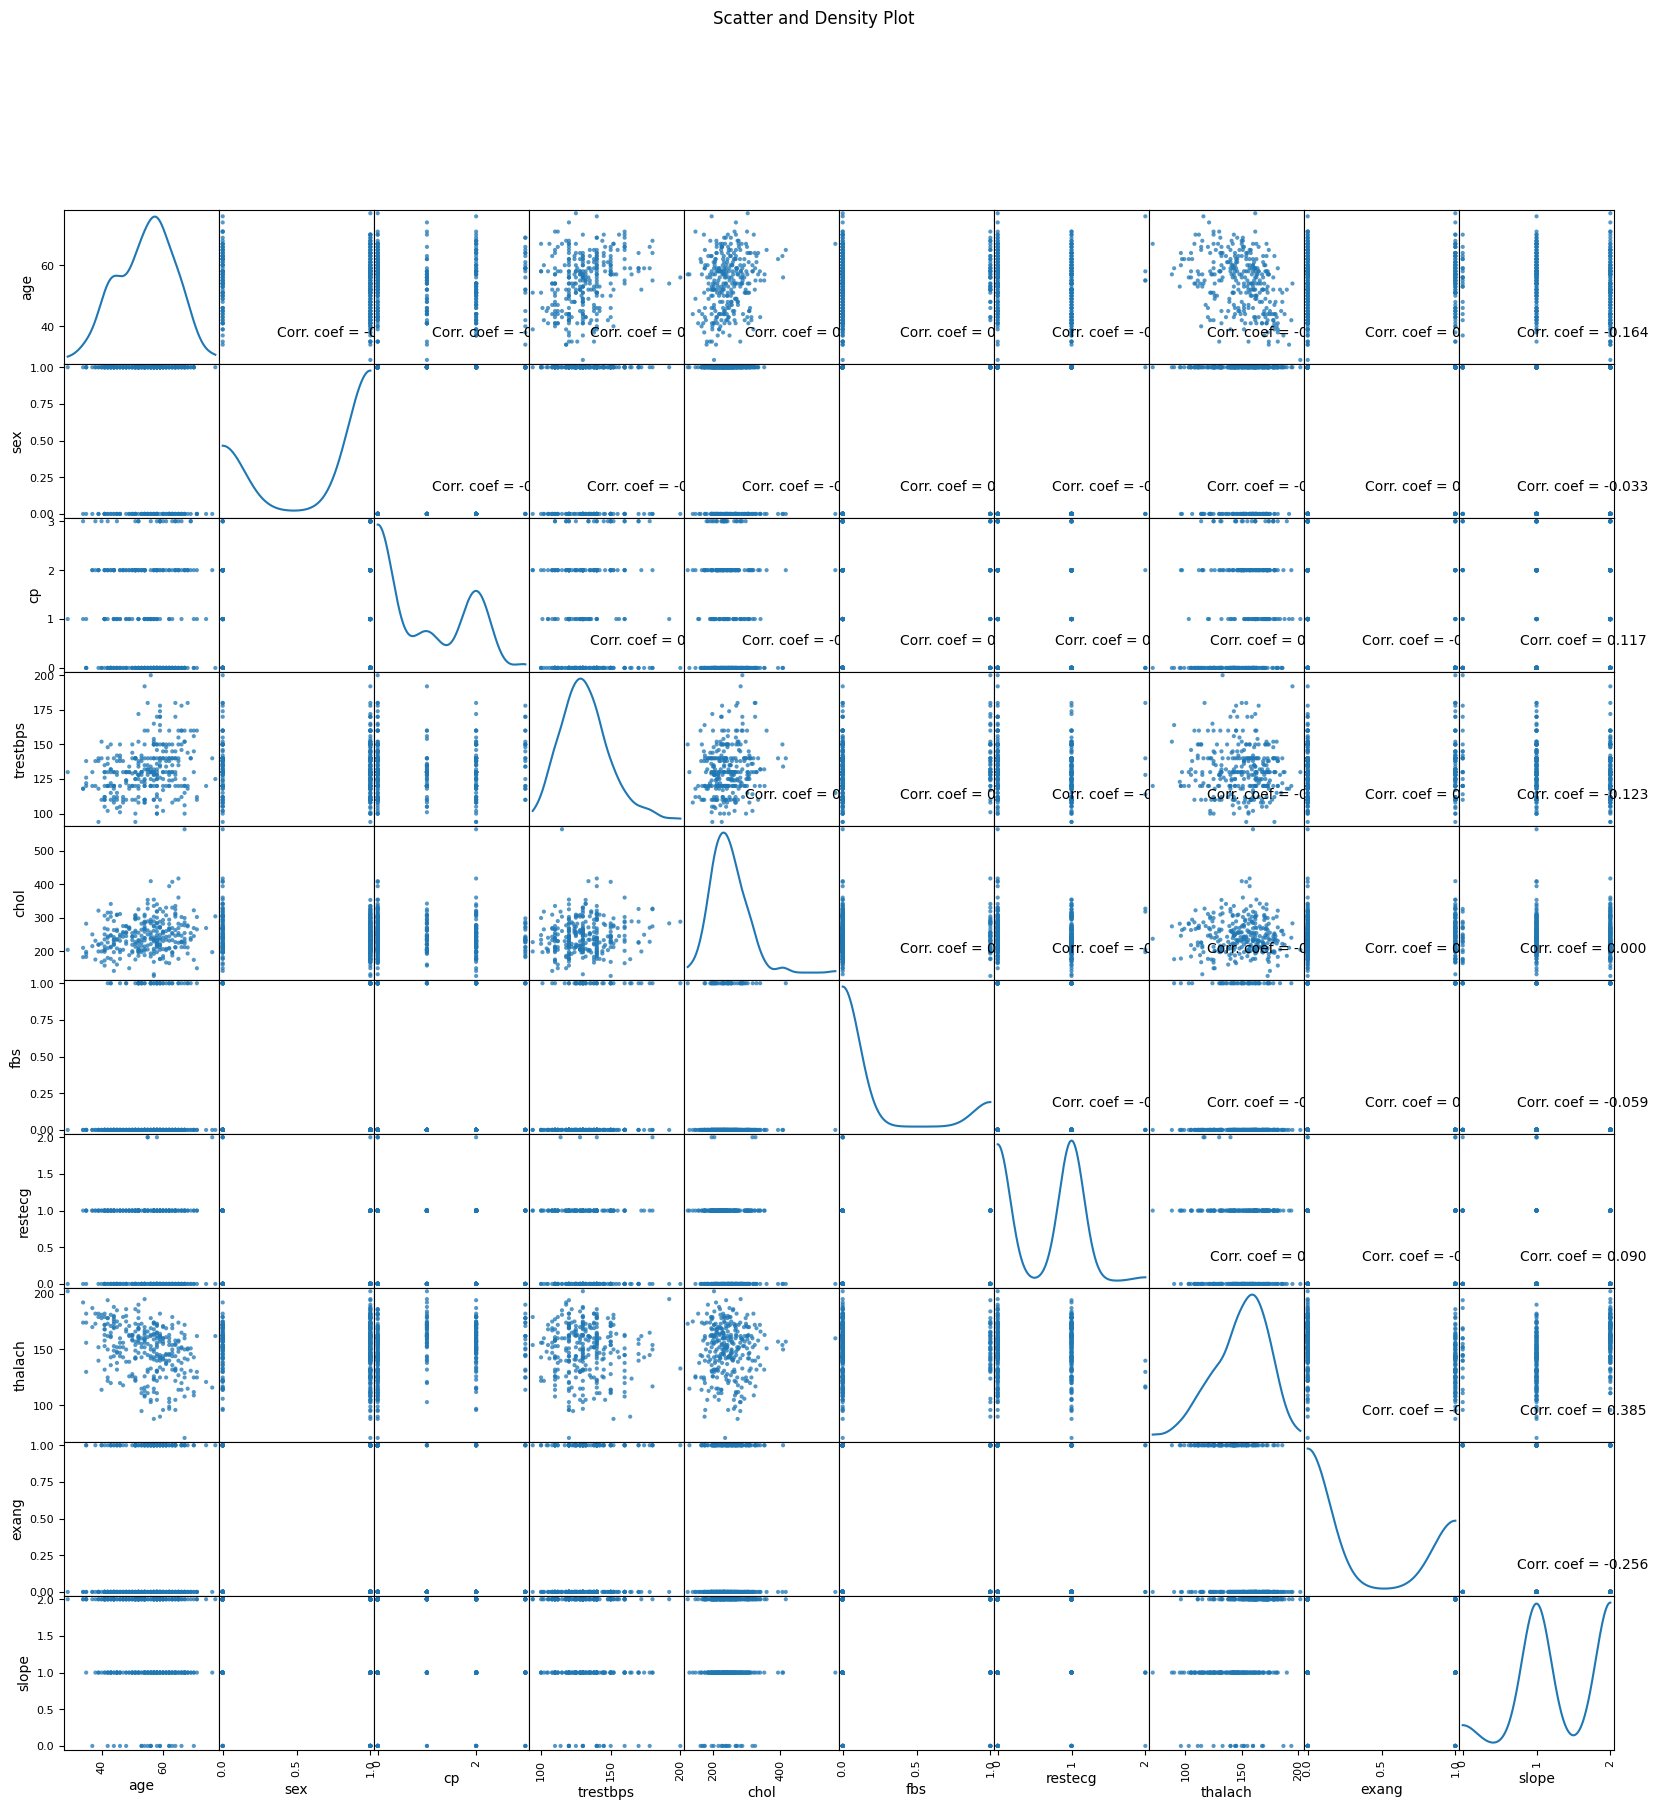

In [11]:
plotScatterMatrix(df_clean, 20, 10)

## Feature Engineering

### Normalization and Standardization
Feature scaling helps ensure that no feature dominates others during modeling. Normalization and Standardization are widely used feature scaling techniques. Normalization typically scales features in the range [0, 1] ensuring they have roughly the same scale. Standardization transforms the data to have zero mean and unit variance, maintaining more information about outliers and not bounding the range.

In [21]:
# Show the initial distribution
def show_distribuition(df, property, label):
    age = df[property]
    plt.figure(figsize=(10,5))
    plt.hist(age, bins=30, alpha=0.5, label={label})
    plt.legend(prop={'size': 16})
    plt.title(f'Histogram with {label} {property}');
    plt.xlabel(property); plt.ylabel('Count');
    plt.show()

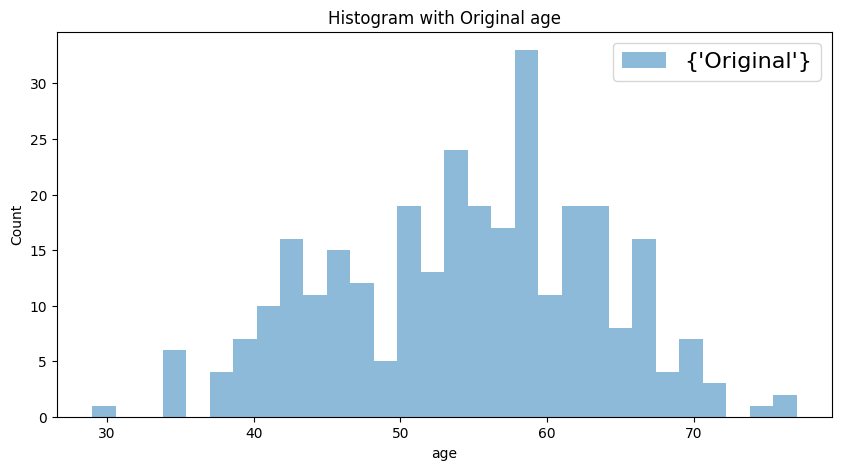

In [22]:
show_distribuition(df_clean, "age", "Original")

In [58]:
# split test and train

from sklearn.model_selection import train_test_split
X = df_clean.drop('target', axis=1)
y = df_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


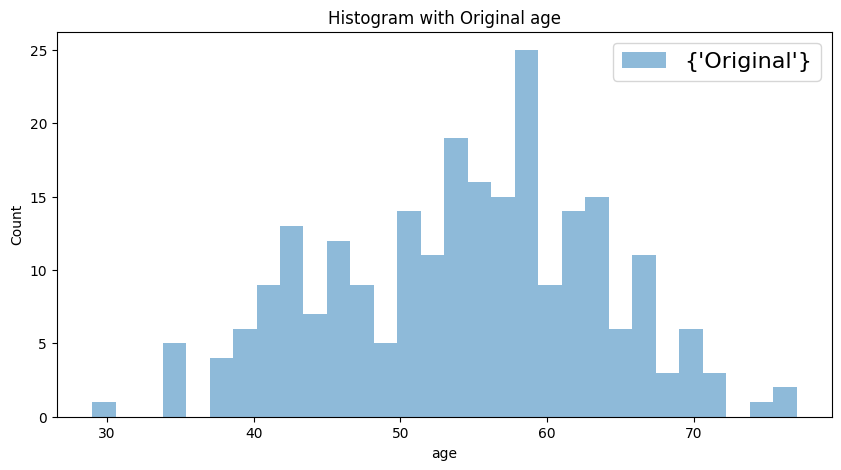

In [59]:
show_distribuition(X_train, "age", "Original")

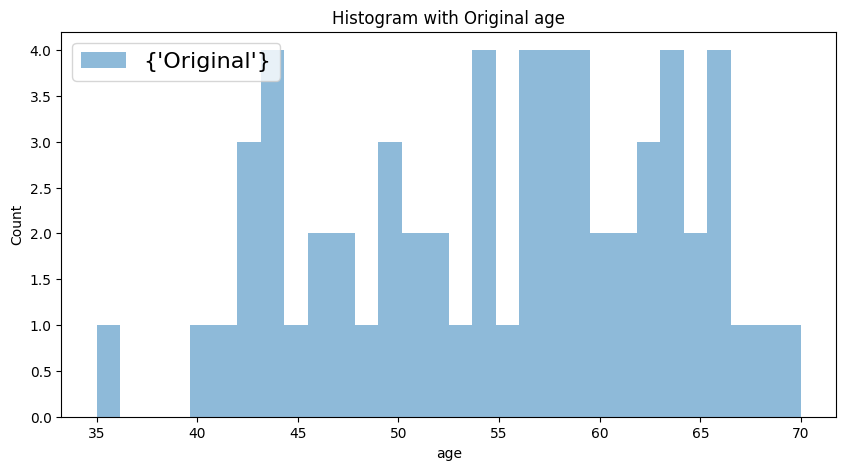

In [60]:
show_distribuition(X_test, "age", "Original")

In [61]:

from sklearn.preprocessing import MinMaxScaler
def normalize_age(df, property, normalizer= None):
    fit = normalizer is None
    if normalizer is None:
        normalizer = MinMaxScaler()
    if fit:
        normalizer.fit_transform(df[property].values.reshape(-1,1))
    else:
        normalizer.transform(df[property].values.reshape(-1,1))
    return df, normalizer

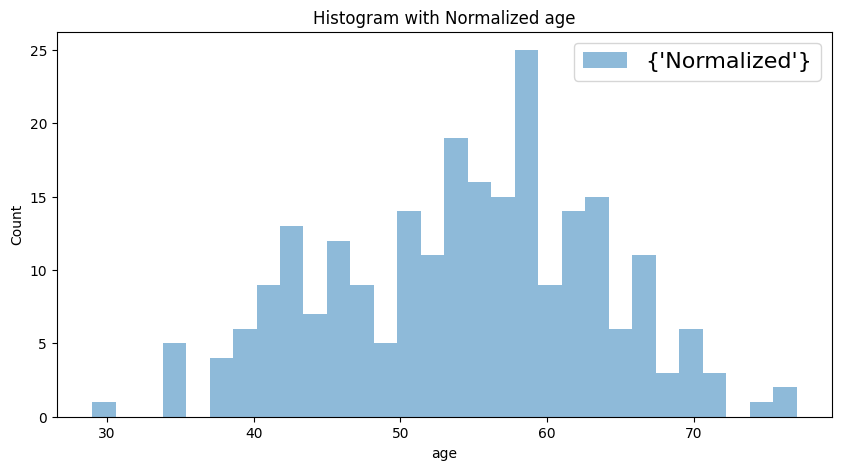

In [62]:
# Normalize 'age' on the training set.
X_train, normalizer = normalize_age(X_train, "age")
show_distribuition(X_train, "age", "Normalized")

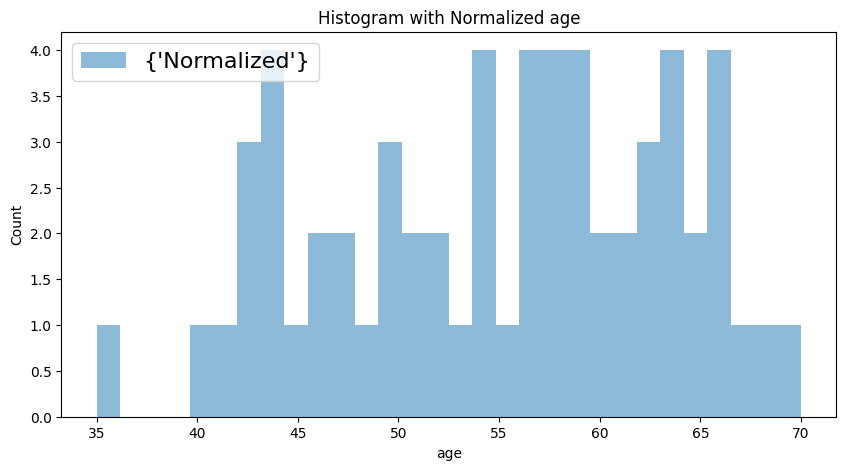

In [63]:
# Normalise 'age' on the test set.
X_test, normalizer = normalize_age(X_test, "age", normalizer)
show_distribuition(X_test, "age", "Normalized")

In [64]:
from sklearn.preprocessing import StandardScaler

def standardizer(df, property, scaler = None):
    fit = scaler is None
    if scaler is None:
        scaler = StandardScaler()
    if fit:
        scaler.fit_transform(df[property].values.reshape(-1,1))
    else:
        df[property] = scaler.transform(df[property].values.reshape(-1,1))
    return scaler

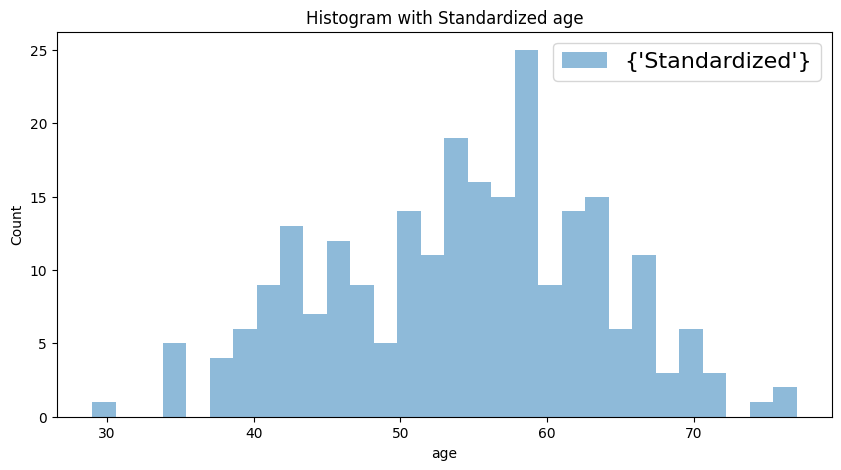

In [65]:
# Standarize age X_train
scaler = standardizer(X_train, "age")
show_distribuition(X_train, "age", "Standardized")

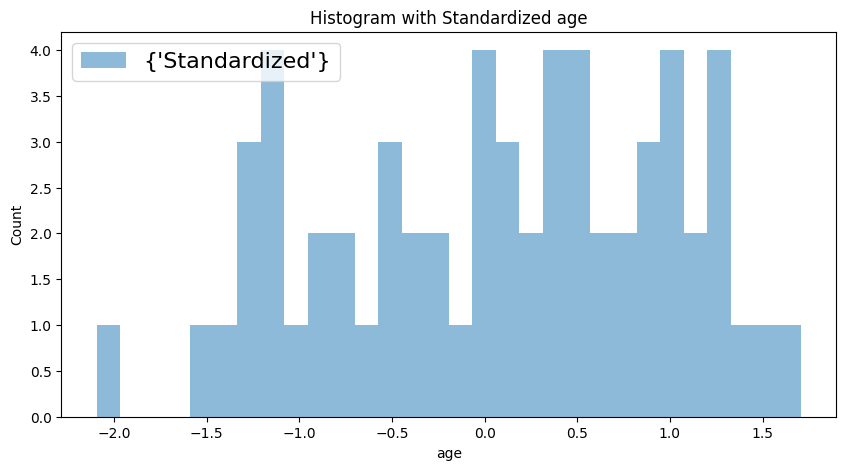

In [66]:
# Standarize age X_test
scaler = standardizer(X_test, "age", scaler)
show_distribuition(X_test, "age", "Standardized")

### Feature Selection

In [68]:
from sklearn.ensemble import RandomForestClassifier

# Define the random forest model and fit to the training data
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [69]:
from sklearn.feature_selection import SelectFromModel

# Use SelectFromModel to select the most important features
sfm = SelectFromModel(rf)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced',
                                                 max_depth=5, n_jobs=-1))

In [70]:
# Transform the training features
X_train_transformed = sfm.transform(X_train)

In [73]:
original_features = df_clean.columns[:-1]
print(f"Original features: {original_features}")

Original features: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'slope', 'ca', 'thal'],
      dtype='object')


In [75]:
# Select the features deemed important by the SelectFromModel
features_bool = sfm.get_support()
selected_features = original_features[features_bool]
print(f"Selected features: {selected_features}")

Selected features: Index(['age', 'cp', 'thalach', 'slope', 'ca', 'thal'], dtype='object')


In [76]:
def plot_feature_importance(model, selected_features, features_bool):
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": rf.feature_importances_[features_bool]
    })
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["feature"], feature_importance["importance"])
    plt.show()

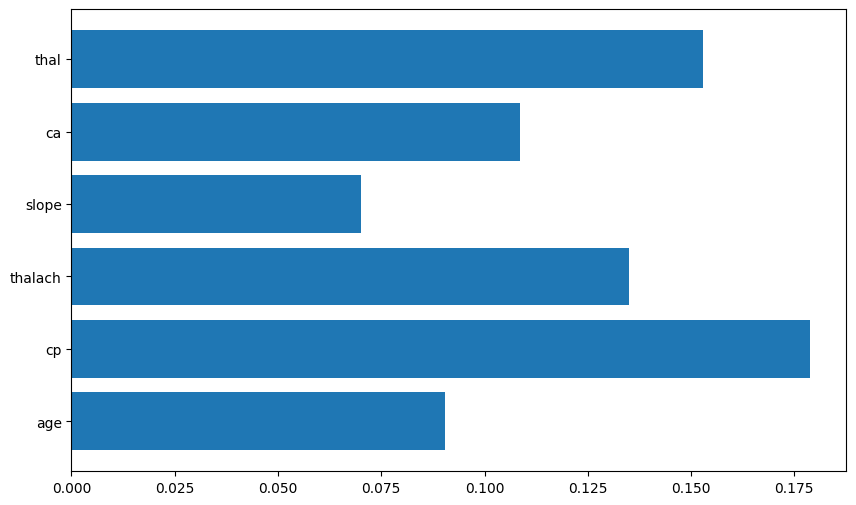

In [77]:
plot_feature_importance(rf, selected_features, features_bool)